# OCR Agent from scratch:

* [Data](Data-Sources.ipynb)
* [Utilities](Data-Processing.ipynb)
* Extract layout features and visual tokens
    * [Cells and grid-lines (tables)](Data-Extraction-1.ipynb)
    * Text-lines, word-level objects, char-level tokens
* [Generate training data](Data-Extraction-3.ipynb)
* [Model architecture](Model-Backbone.ipynb)
* [Traversal strategies](Traversal-Layout.ipynb)
* [Reader Agent](Agent-LM.ipynb)
* [Leverage synthetic training data](Data-Gen.ipynb)
* [Optimization for production](Optimization.ipynb)


### Detect and extract textual features

( Default parameters set for the target resolution of the target dataset:
for different environment parameters should be readjusted. )

In [1]:
import cv2
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path

In [2]:
from scripts.extract import *

In [3]:
samples = [str(x)[12:-4] for x in Path('./data/images').glob('*.png')]
len(samples)

8631

In [4]:
source = np.random.choice(samples)

In [5]:
print(source)
image = load_image(source)
# show image
#Image.fromarray(image)

cnd-nr73.fr-3


First we check for the grid-lines presence. We extract the cells if present and remove the lines for the easier text extraction.

In [6]:
# borders removed, cells detected
mask, vlines, hlines, cells = get_grid(image)

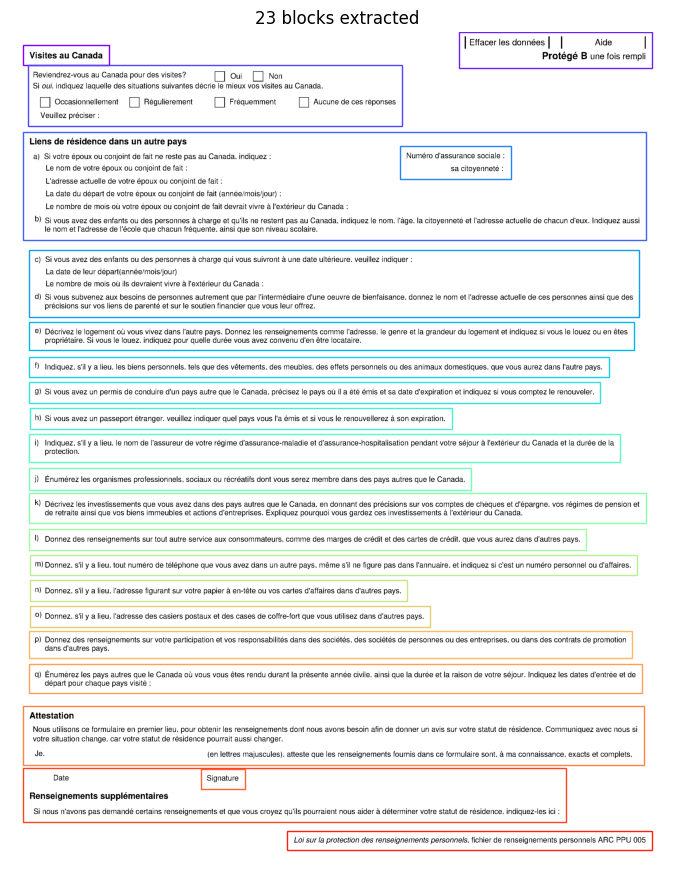

In [7]:
# now we extract from the mask!
blocks = extract_blocks(mask, visual=False)
#blocks = filter_boxes(blocks, image.shape)
# default top-down-left-right order
blocks = sorted(blocks, key=lambda x:(x[1]//111, x[2]//111))

fig, ax = plt.subplots(figsize=(11, 11))
ax.imshow(mask, 'gray')
for b, (x, y, w, h) in enumerate(blocks):
    color = plt.cm.rainbow(b/len(blocks))
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor='none'))
plt.title(f'{len(blocks)} blocks extracted')
plt.axis('off')
plt.show()

At this point we can focus on extraction textual features.

### Extract text-lines

In [8]:
def extract_textlines(mask, f=3, kernel=(1, 11), threshold=20, visual=False):
    output = resample(mask, f)
    output = cv2.erode(output, np.ones(kernel, np.uint8), iterations=1)
    output = cv2.threshold(output, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    visual_check(output, visual)
    c, h = cv2.findContours(output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    C = [cv2.boundingRect(c[i]) for i in range(len(c))]
    return np.array([box for box in C if box[-1] > threshold/f]) * f


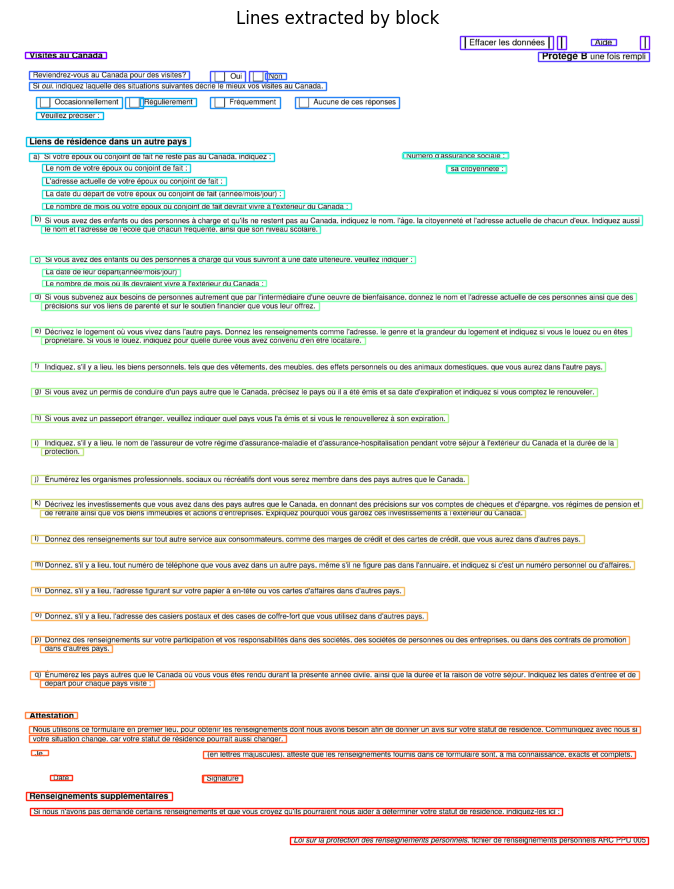

,left,top,width,height
count,63.000000,63.000000,63.000000,63.000000
mean,477.476190,1253.476190,981.000000,31.428571
std,661.918226,1028.924961,831.875223,6.639846
min,60.000000,17.000000,34.000000,22.000000
25%,83.000000,286.000000,245.500000,28.000000
50%,119.000000,967.000000,640.000000,28.000000
75%,752.500000,2210.500000,1652.500000,34.000000
max,2455.000000,3135.000000,2383.000000,49.000000


In [9]:
lines = []    
for b, (X, Y, W, H) in enumerate(blocks):
    C = [[X + x - 1, Y + y - 1, w + 1, h + 1, b]
         for x, y, w, h in extract_textlines(mask[Y:Y + H,X:X + W], visual=False)]
    # in the block: lines only ordered by `top` (y)
    lines += sorted(C, key=lambda c:c[1])

fig, ax = plt.subplots(figsize=(11, 11))
ax.imshow(mask, 'gray')
for l, (x, y, w, h, b) in enumerate(lines):
    color = plt.cm.rainbow(l/len(lines))
    ax.add_patch(patches.Rectangle((x - 1, y - 1), w, h, linewidth=1, edgecolor=color, facecolor='none'))
plt.title('Lines extracted by block')
plt.axis('off')
plt.show()

# show stats
stats = pd.DataFrame(lines, columns=BOX + ['block-index']).describe()
stats.iloc[:,:4].style.background_gradient()

In [10]:
# estimated text-line height
LH = int(stats.loc['50%','height'].round())

### Extract word-level objects

In [11]:
def extract_words(mask, f=1, kernel=(1, 11), threshold=100, visual=False):
    #output = 255 - mask if np.median(mask) == 0 else mask # catch inverce boxes
    output = resample(mask, f)
    output = cv2.erode(output, np.ones(kernel, np.uint8), iterations=1)
    output = cv2.threshold(output, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    visual_check(output, visual)
    contours, _ = cv2.findContours(output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return np.array([cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > threshold]) * f


In [12]:
words = []    
for l, (X, Y, W, H, b) in enumerate(lines):
    # height adjusted for failed lines
    C = [[X + x, Y, w, H if H < LH * 2 else h + y, b, l]
         for x, y, w, h in extract_words(mask[Y:Y + H,X:X + W], visual=False)]
    # in the line: words only ordered by `left` (x)
    words += sorted(C, key=lambda c:c[0])


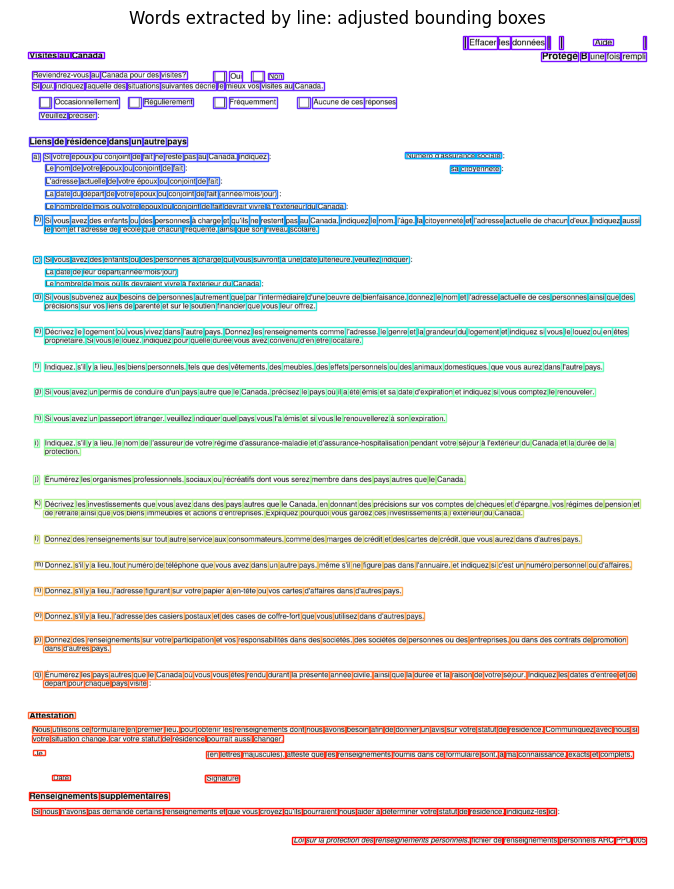

In [13]:
    fig, ax = plt.subplots(figsize=(11, 11))
    ax.imshow(mask, 'gray')
    for i, (x, y, w, h, b, l) in enumerate(words):
        color = plt.cm.rainbow(i/len(words))
        ax.add_patch(patches.Rectangle((x - 1, y - 1), w, h, linewidth=1, edgecolor=color, facecolor='none'))
    plt.title('Words extracted by line: adjusted bounding boxes')
    plt.axis('off')
    plt.show()

In [14]:
stats = pd.DataFrame(words, columns=BOX + ['block-index','line-index'])
stats['area'] = stats['width'] * stats['height']
stats = stats[BOX + ['area']].describe()
stats.style.background_gradient()

,left,top,width,height,area
count,607.000000,607.000000,607.000000,607.000000,607.000000
mean,966.622735,1510.125206,98.031301,31.108731,3028.794069
std,673.560228,832.264465,66.682792,4.080628,2089.903918
min,72.000000,17.000000,14.000000,22.000000,589.000000
25%,358.000000,756.000000,46.500000,28.000000,1443.000000
50%,834.000000,1387.000000,80.000000,31.000000,2548.000000
75%,1482.000000,2162.000000,127.500000,34.000000,3988.500000
max,2466.000000,3135.000000,462.000000,49.000000,14763.000000


In [15]:
# validate area threshold used in extract_
int(stats.loc['min','area'].round())

589

### Extract character-level tokens

In [16]:
#def extract_tokens(mask, f=0.1, kernel=(17, 1), visual=False): upsampling sometimes makes sense
def extract_tokens(mask, f=1, kernel=(11, 1), visual=False):
    #output = 255 - mask if np.median(mask) == 0 else mask # catch inverce boxes
    output = cv2.erode(mask, np.ones(kernel, np.uint8), iterations=1)
    output = cv2.threshold(output, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    visual_check(output, visual, figsize=(4, 4))
    c, h = cv2.findContours(output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return np.array([cv2.boundingRect(c[i]) for i in range(len(c))])


In [17]:
tokens = []
for i, (X, Y, W, H, b, l) in enumerate(words):
    C = [[X + x, Y, w, H, b, l, i]
         for x, y, w, h in extract_tokens(mask[Y:Y + H,X:X + W], visual=False)]
    # in the word: tokens only ordered by `left` (x)
    tokens += sorted(C, key=lambda c:c[0])

In [18]:
tokens = pd.DataFrame(tokens, columns=BOX + ['block-index','line-index','word-index'])
print(len(tokens))
tokens = tokens.drop_duplicates(subset=BOX, keep='last')
print(len(tokens))

4046
4046


    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image, 'gray')
    for i, (x, y, w, h, b, l, _) in enumerate(tokens.values):
        color = plt.cm.rainbow(i/len(tokens))
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor='none'))
    plt.title(f'Character-level tokens {len(tokens)}')
    plt.show()

In [19]:
stats = pd.DataFrame(np.array(tokens)[:,:4], columns=BOX).describe()
stats.style.background_gradient()

,left,top,width,height
count,4046.000000,4046.000000,4046.000000,4046.000000
mean,1053.837865,1600.027187,10.619624,30.792388
std,641.370710,843.747247,4.541298,3.780818
min,77.000000,17.000000,2.000000,22.000000
25%,501.000000,922.000000,7.000000,28.000000
50%,960.500000,1587.000000,12.000000,31.000000
75%,1566.500000,2355.000000,14.000000,34.000000
max,2471.000000,3135.000000,40.000000,49.000000


### Setup for reading
Text reading goes by layout blocks and line by line.
To catch our blocks extraction misses we clear the processed from the mask as we go.

In [20]:
def read_line(mask, box, bi, li, wi, lh):
    X, Y, W, H = box
    # height adjusted for failed lines
    C = [[X + x, Y, w, H if H < lh * 1.25 else h + y, bi, li]
         for x, y, w, h in extract_words(mask[Y:Y + H,X:X + W])]
    # in the line: words only ordered by `left` (x)
    words = sorted(C, key=lambda c:c[0])
        
    tokens = []
    for i, (X, Y, W, H, bi, li) in enumerate(words, wi):
        C = [[X + x, Y, w, H, bi, li, i] for x, y, w, h in extract_tokens(mask[Y:Y + H,X:X + W])]
        # in the word: tokens only ordered by `left` (x)
        tokens += sorted(C, key=lambda c:c[0])
        # remove processed word from the map
        mask[Y - 1:Y + H + 2,X:X + W] = 255
    return words, tokens


    lh = LH
    mask, vlines, hlines, cells = get_grid(image)
    
    lines, words, tokens = [], [], []
    
    if len(cells) > 0:
        for bi in cells.index:
            X, Y, W, H = cells.loc[bi, BOX].values
            ln = [[X + x - 1, Y + y - 1, w + 1, h + 1]
                  for x, y, w, h in extract_textlines(mask[Y:Y + H,X:X + W])]
            # in the block: lines only ordered by `top` (y)
            for li, box in enumerate(sorted(ln, key=lambda l:l[1]), len(lines)):
                wrd, tkn = read_line(mask, box, bi, li, len(words), lh)
                words += wrd
                tokens += tkn
                lines.append(box + [bi])
                
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(mask, 'gray')
    for i, (x, y, w, h, bi) in enumerate(lines):
        color = plt.cm.rainbow(i/len(lines))
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor='none'))
    plt.show()                

    # extract text blocks from the mask residual
    boxes = pd.DataFrame()
    blocks = extract_blocks(mask)
    stop = 3
    while len(blocks) > 0 and stop > 0:
        print('extracting blocks...')
        # make sure we do not lose any start from the smallest
        blocks = sorted(blocks, key=lambda b:b[2] * b[3], reverse=True)
        for bi, (X, Y, W, H) in enumerate(blocks, len(cells) + len(boxes)):
            ln = [[X + x - 1, Y + y - 1, w + 1, h + 1]
                  for x, y, w, h in extract_textlines(mask[Y:Y + H,X:X + W])]
            # in the block: lines only ordered by `top` (y)
            for li, box in enumerate(sorted(ln, key=lambda l:l[1]), len(lines)):
                wrd, tkn = read_line(mask, box, bi, li, len(words), lh)
                words += wrd
                tokens += tkn
                lines.append(list(box) + [bi])

        blocks = pd.DataFrame(blocks, columns=BOX)
        blocks['type'] = BLOCK
        boxes = pd.concat([boxes, blocks])
        blocks = extract_blocks(mask)
        stop -= 1
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(mask, 'gray')
    for i, (x, y, w, h, bi) in enumerate(lines):
        color = plt.cm.rainbow(i/len(lines))
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor='none'))
    plt.show()

In [21]:
def extract_layout(image, lh=40, stop=3):
    """
    Extract layout features and visual tokens
    """    
    mask, vlines, hlines, cells = get_grid(image)
    
    lines, words, tokens = [], [], []
    
    if len(cells) > 0:
        for bi in cells.index:
            X, Y, W, H = cells.loc[bi, BOX].values
            ln = [[X + x - 1, Y + y - 1, w + 1, h + 1]
                  for x, y, w, h in extract_textlines(mask[Y:Y + H,X:X + W])]
            # in the block: lines only ordered by `top` (y)
            for li, box in enumerate(sorted(ln, key=lambda l:l[1]), len(lines)):
                wrd, tkn = read_line(mask, box, bi, li, len(words), lh)
                words += wrd
                tokens += tkn
                lines.append(box + [bi])

    # extract text blocks from the mask residual
    boxes = pd.DataFrame()
    blocks = extract_blocks(mask)
    while len(blocks) > 0 and stop > 0:
        # make sure we do not lose any start from the smallest
        blocks = sorted(blocks, key=lambda b:b[2] * b[3], reverse=True)
        for bi, (X, Y, W, H) in enumerate(blocks, len(cells) + len(boxes)):
            ln = [[X + x - 1, Y + y - 1, w + 1, h + 1]
                  for x, y, w, h in extract_textlines(mask[Y:Y + H,X:X + W])]
            # in the block: lines only ordered by `top` (y)
            for li, box in enumerate(sorted(ln, key=lambda l:l[1]), len(lines)):
                wrd, tkn = read_line(mask, box, bi, li, len(words), lh)
                words += wrd
                tokens += tkn
                lines.append(list(box) + [bi])

        blocks = pd.DataFrame(blocks, columns=BOX)
        blocks['type'] = BLOCK
        boxes = pd.concat([boxes, blocks])
        blocks = extract_blocks(mask)
        stop -= 1
    
    boxes = pd.concat([cells, boxes, vlines, hlines], ignore_index=True)

    # mask should be blank at this point
    assert len((255 - mask).nonzero()) < 10
    
    tokens = pd.DataFrame(tokens, columns=BOX + ['block-index','line-index','word-index'])
    tokens = tokens.drop_duplicates(subset=BOX, keep='last')
    tokens['type'] = CHAR
    
    lines = pd.DataFrame(lines, columns=BOX + ['block-index'])
    words = pd.DataFrame(words, columns=BOX + ['block-index','line-index'])
    return tokens, words, lines, boxes
    

In [22]:
tokens, words, lines, boxes = extract_layout(image, LH)

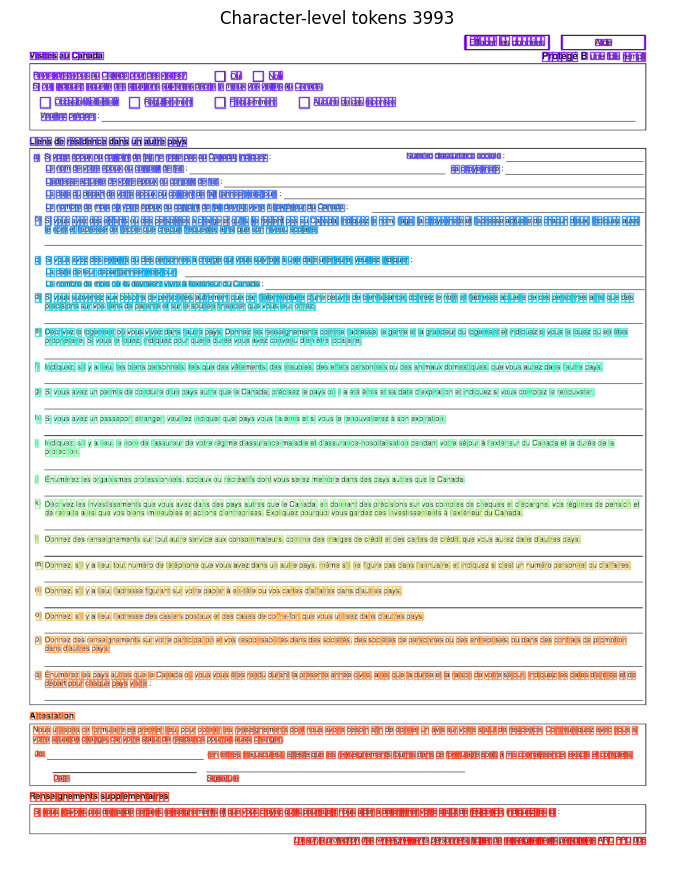

In [23]:
    fig, ax = plt.subplots(figsize=(11, 11))
    ax.imshow(image, 'gray')
    for i, (x, y, w, h, bi, li, wi, t) in enumerate(tokens.values):
        color = plt.cm.rainbow(i/len(tokens))
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor='none', alpha=0.75))
    plt.title(f'Character-level tokens {len(tokens)}')
    plt.axis('off')
    plt.show()